In [1]:
#Import Statemetns
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import librosa.display
import random
from torchvision import models
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from torch.utils.data import Dataset
import torchaudio

C:\Users\patel\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\patel\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\patel\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
#Check for GPU Availability
torch.cuda.is_available()

False

In [3]:
#Datapath to dataset
data_path = Path('C:/Users/patel/Downloads/archive')
meta_file = data_path/'UrbanSound8K.csv'
df_meta = pd.read_csv(meta_file)
df_meta.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
#File path datagrame
df = pd.DataFrame()
df_meta['relative_path'] = '/fold' + df_meta['fold'].astype(str) + '/' + df_meta['slice_file_name'].astype(str)
df = df_meta[['relative_path', 'classID']]
df.head()

,relative_path,classID
0,/fold5/100032-3-0-0.wav,3
1,/fold5/100263-2-0-117.wav,2
2,/fold5/100263-2-0-121.wav,2
3,/fold5/100263-2-0-126.wav,2
4,/fold5/100263-2-0-137.wav,2


In [5]:
#Ouput Audio sound
import IPython.display as ipd
idx = random.randint(0, len(df))
audio_file, label  = str(data_path) + df.loc[idx, 'relative_path'], df_meta.loc[idx, 'class']
print("True class: \n", label)
ipd.Audio(audio_file)

True class: 
 engine_idling


#### The methods provided in this class include:

1. open: Load an audio file and return the signal as a tensor along with the sample rate.
2. rechannel: Convert the given audio to the desired number of channels (e.g., mono to stereo or stereo to mono).
3. resample: Resample the audio to a new sample rate.
4. pad_trunc: Pad or truncate the signal to a fixed length duration.
5. time_shift: Shift the signal to the left or right by some percent.
6. spectro_gram: Generate a spectrogram from the audio signal.
7. spectro_augment: Augment the spectrogram by masking out some sections of it in both the frequency and time dimensions to prevent overfitting.

In [6]:
class AudioUtil():
    """
    Load an audio file. Return the signal as a tensor and a sample rate
    """
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return sig, sr
    
    """
    Convert the given audio to desired number of channels
    """
    @staticmethod
    def rechannel(audio, new_channel):
        sig, sr = audio
        if (sig.shape[0] == new_channel):
            return audio
        if (new_channel == 1):
          # Convert from stereo to mono by selecting only the first channel
          resig = sig[:1, :]
        else:
          # Convert from mono to stereo by duplicating the first channel
          resig = torch.cat([sig, sig])
        return ((resig, sr))
     
    """
    Since resample applies to a single channel, we resample one channel at a time.
    """
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
          # Nothing to do
          return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])
        return ((resig, newsr))
    
    """
    Pad(or truncate) the signal to a fixed length duration 
    of "max_ms" in milliseconds
    """
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000*max_ms
        
        if (sig_len > max_len):
            # Truncate
            sig = sig[:, :max_len]
        elif (sig_len < max_len):
            # Pad
            pad_begin_len = random.randint(0, max_len-sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            sig = torch.cat((pad_begin, sig, pad_end), 1)
        return (sig, sr)
    
    """
    Shifts the signal to the left or right by some percent.
    Values at the end are 'wrapped around' to the start of the
    transformed signal
    """
    @staticmethod
    def time_shift(aud, shift_limit):
        sig, sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)
    
    """
    Generate a Spectrogram
    """
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig, sr = aud
        top_db = 80
        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
        
        # Convert to dB
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return spec
    
    """
    Augment the Mel Spectrogram by masking out some sections of it in
    both the freq dimension and the time dimension to prevent overfitting.
    The masked sections are replaced with the mean value
    """
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec
        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)
        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)
        return aug_spec

* A sample rate of 44100 Hz is commonly used in audio processing and is the standard sample rate for audio CDs.
* Duration of samples is 4 seconds.
* Setting self.channel = 2 suggests that the dataset expects stereo audio data.
* A value of 0.4 for shift means that the signal can be shifted up to 40% of its total length.

In [7]:
class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.4
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        audio_file = self.data_path + self.df.loc[idx, 'relative_path']
        class_id = self.df.loc[idx, 'classID']
        aud = AudioUtil.open(audio_file)
        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)
        dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
        shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
        # print(aug_sgram.view(aug_sgram.size(0), -1).size())
        return aug_sgram, class_id  

#### Preprocessing

* Pytorch random_split is being used.

* starts with 60/20/20 ratio.

In [8]:
myds = SoundDS(df, data_path)

# Determine the sizes of train, validation, and test sets
num_items = len(myds)
num_train_val = round(num_items * 0.8)
num_test = num_items - num_train_val    # 20% of all data for testing
num_train = round(num_train_val * 0.75)  # 75% of the remaining data for training
num_val = num_train_val - num_train   # Remaining 20% for valirdation

# Split the dataset into training, validation, and test sets
train_val_ds, test_ds = random_split(myds, [num_train_val, num_test])

# Split the remaining portion into validation and test sets
train_ds, val_ds = random_split(train_val_ds, [num_train, num_val])

# Create data loaders for training, validation, and test sets
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

#### Visualizing Spectrograms Using Matplotlib

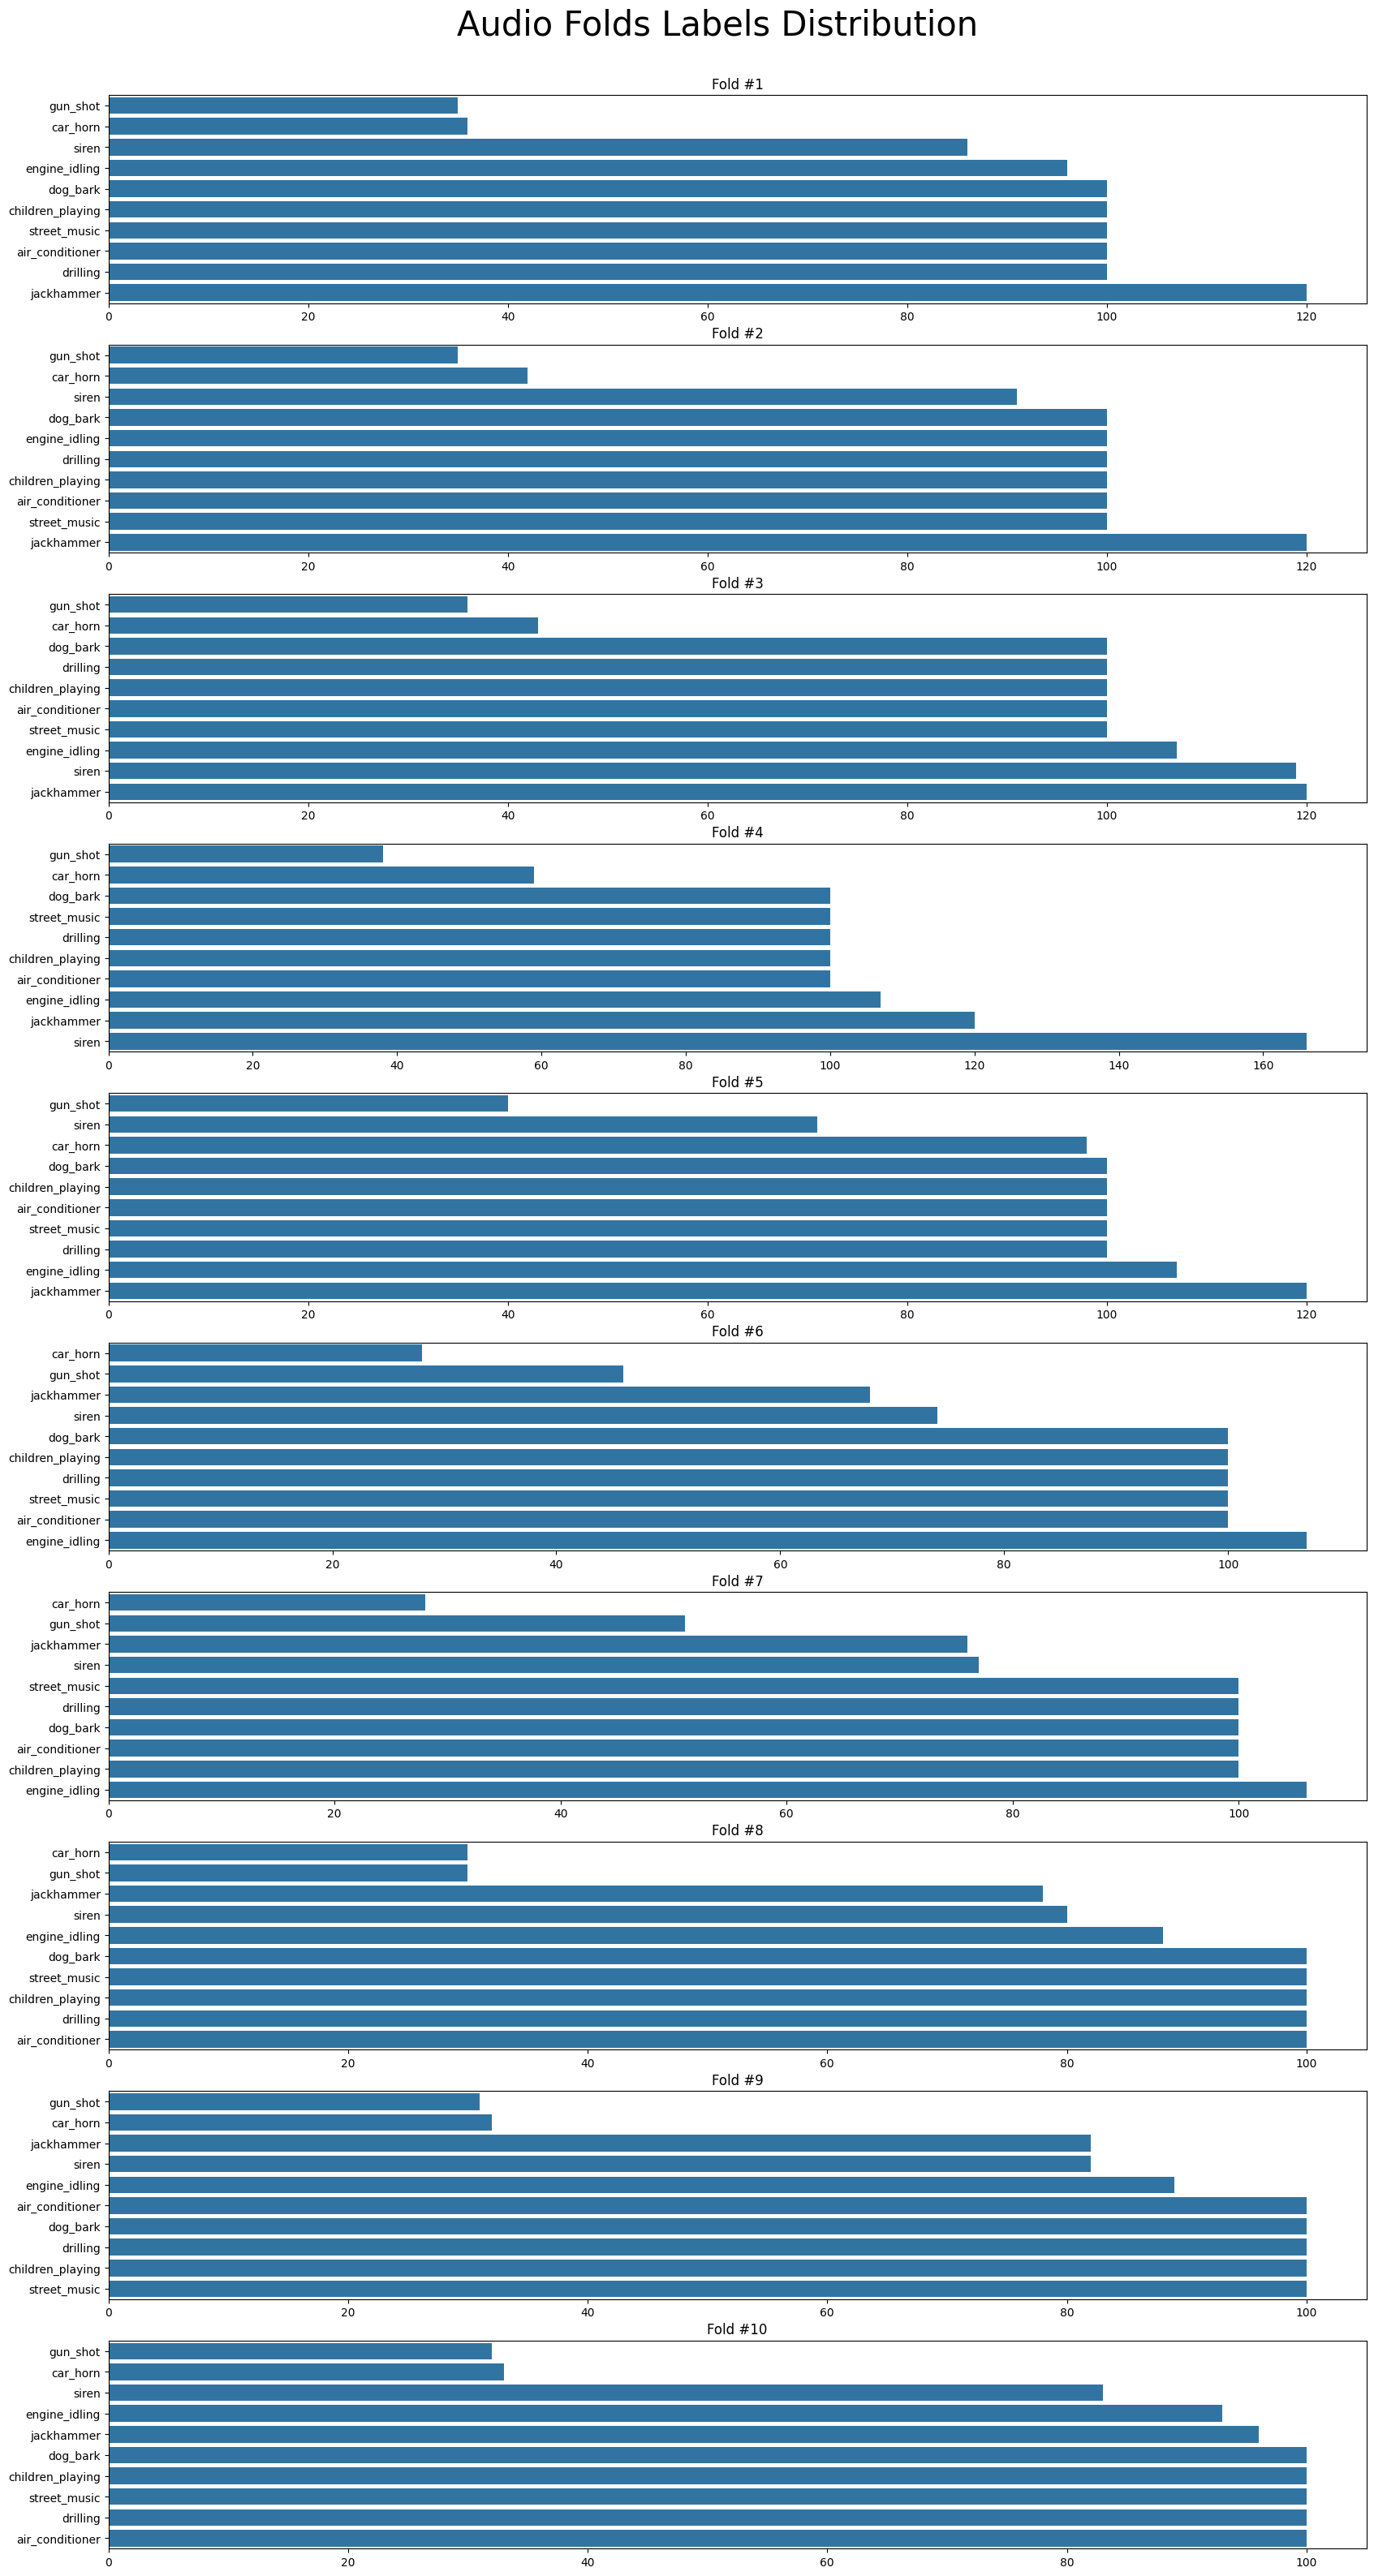

In [9]:
# View Dataset Folds Distribution
fig = plt.figure(figsize=(20, 36))
fig.suptitle('Audio Folds Labels Distribution', fontsize=30)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

folds = sorted(list(df_meta['fold'].drop_duplicates()))
fold_groups = df_meta.groupby(by='fold')

for fold in folds:
    query = fold_groups.get_group(fold)
    class_distribution = query['class'].value_counts().sort_values()
    
    plt.subplot(len(folds), 1, fold)
    plt.title(f'Fold #{fold}')
    warnings.filterwarnings("ignore")
    sns.barplot(x=class_distribution.values, y=list(class_distribution.keys()));


Shape of data: 
 torch.Size([16, 2, 64, 344])
Shape of labels: 
 torch.Size([16])


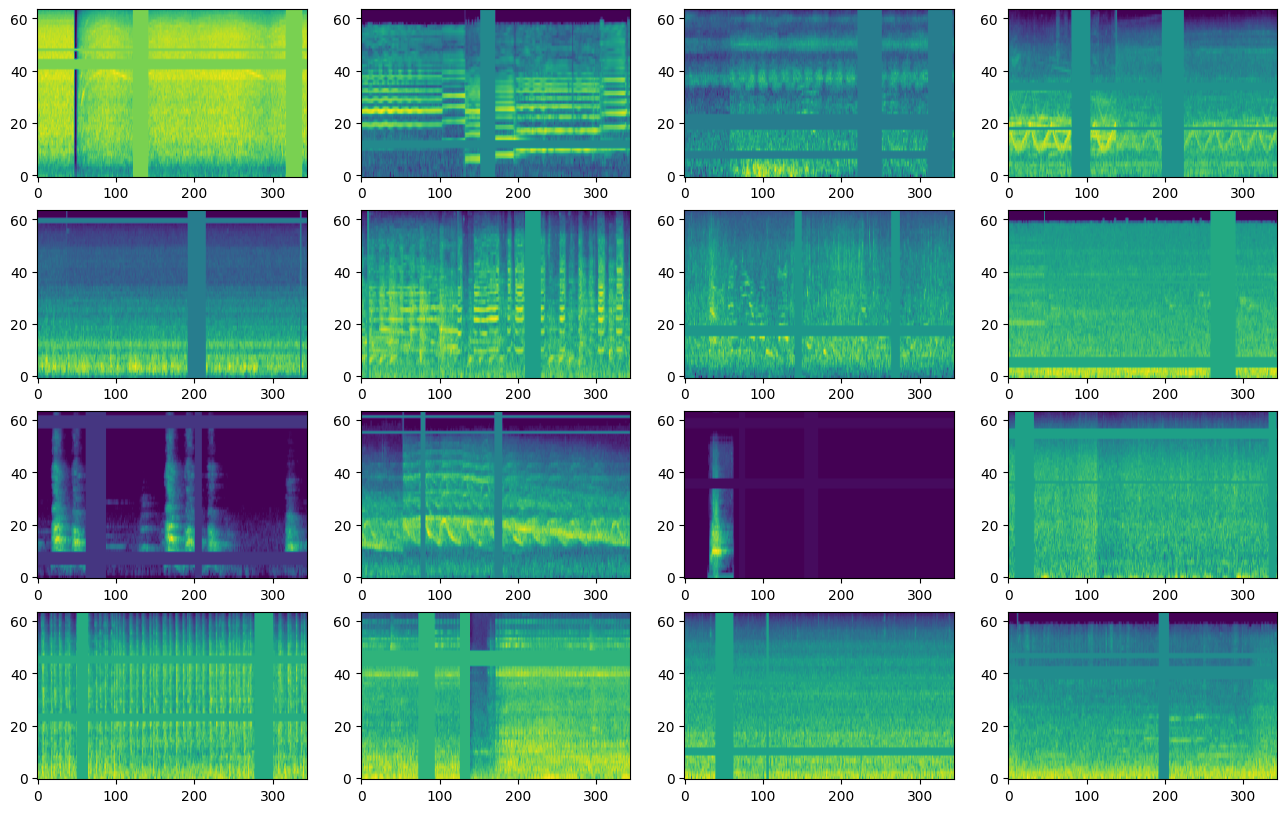

In [10]:
def plot_spectrogram(batch_data, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(4,4, figsize=(16,10))
    for idx, data in enumerate(batch_data):
        row, col = idx//4, idx%4
        ax = axs[row, col]
        spec = data[0]
        im = ax.imshow(spec, origin='lower', aspect=aspect)
        if xmax:
            ax.set_xlim((0, xmax))
            fig.colorbar(im, ax=ax)
            plt.show(block=False)

batch_data, label = next(iter(train_dl))
print("Shape of data: \n", batch_data.shape)
print("Shape of labels: \n", label.shape)
plot_spectrogram(batch_data)

# Method 1: Multiclass Logistic Regression

In [21]:
#Prepare Data
X_train_simple = []
y_train_simple = []
X_test_simple = []
y_test_simple = []

# Convert tensor to numpy array
for feature, label in train_ds:
    X_train_simple.append(feature.numpy())  
    y_train_simple.append(label)
    
X_train_sim = np.array(X_train_simple)    
X_train_sim = X_train_sim.reshape(X_train_sim.shape[0], -1)

y_train_sim = np.array(y_train_simple)  

# Convert tensor to numpy array
for feature, label in test_ds:
    X_test_simple.append(feature.numpy())  
    y_test_simple.append(label)   
    
X_test_sim = np.array(X_test_simple)    
X_test_sim = X_test_sim.reshape(X_test_sim.shape[0], -1)

y_test_sim = np.array(y_test_simple)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize the model
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Fit the model
lr_model.fit(X_train_sim, y_train_sim)

# Predictions
y_pred = lr_model.predict(X_test_sim)


accuracy = accuracy_score(y_test_sim, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.41237113402061853


# Method 2: Feed Forward Neural Netowrk

* input size is 2 * 64 * 344 = 44032
  * 2 channels
  * 64 frequency bins in each spectrogram
  * 344 number of time steps in each spectrogram

In [11]:
class UrbanSoundNN(torch.nn.Module):
    def __init__(self):
        super(UrbanSoundNN, self).__init__()
        self.fc1 = torch.nn.Linear(2 * 64 * 344, 128)  # Input size adjusted for UrbanSound8K spectrogram shape
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)  # Output size adjusted for the number of classes in UrbanSound8K
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        # print(x.shape[0])
        x = self.fc1(x)
        x = self.relu(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
def train_model(model, optimizer, train_loader, val_loader):
    criterion = torch.nn.CrossEntropyLoss()
    train_loss = []
    val_loss = []
    
    val = float('inf')
    counter = 0
    moveOn = True
    epoch = 0
    
    #Condition to stop, only if moveON is false (Early Stopping Condition)
    
    while moveOn == True:
        # Loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0
        running_val_loss = 0.0
        running_val_acc = 0.0
        correct = 0
        total = 0
        model.train()
        for data in train_loader:
            inputs, labels = data
            # Flatten the input
            inputs = inputs.view(inputs.size(0), -1)  
            # Zero the parameter gradients
            optimizer.zero_grad()  

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        running_acc = correct / total
        running_loss = running_loss / len(train_loader)
        
        correct = 0
        total = 0
        
        # model validation
        model.eval()
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                # Flatten the input
                inputs = inputs.view(inputs.size(0), -1) 
                #Forward Pass and calculate validation loss
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                # Calculate validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        running_val_acc = correct / total
        running_val_loss = running_val_loss / len(val_loader)
        train_loss.append(running_loss)
        val_loss.append(running_val_loss)
        # Print the loss, accuracy after each epoch
        print('[%d] loss: %.3f |  Val loss: %.3f | acc: %.2f  | Val acc: %.2f | ' % (epoch + 1, running_loss, running_val_loss, running_acc, running_val_acc))
        
        #increase epoch by 1
        epoch += 1
        
        #Early stopping condition, when loss increases for 5 epochs
        if running_val_loss < val:
            val = running_val_loss
            counter = 0
        else:
            counter += 1
            if counter == 5:
                moveOn = False
            
  
    
    return train_loss, val_loss, model, epoch

#Test the model accoringly
def test_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            # Flatten the input
            inputs = inputs.view(inputs.size(0), -1)  
            #Forward Pass and check for labels
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    #Print test accuracy        
    print('Testing accuracy is: %d %%' % (100 * correct / total))


In [13]:
# Update hyperparameters and variables(epochs, learning rate, batch size, optimizer)

learning_rate = 0.001
batch_size = 64
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

[1] loss: 2.989 |  Val loss: 1.952 | acc: 0.26  | Val acc: 0.31 | 
[2] loss: 1.798 |  Val loss: 1.710 | acc: 0.37  | Val acc: 0.41 | 
[3] loss: 1.648 |  Val loss: 1.603 | acc: 0.41  | Val acc: 0.42 | 
[4] loss: 1.569 |  Val loss: 1.535 | acc: 0.43  | Val acc: 0.44 | 
[5] loss: 1.523 |  Val loss: 1.526 | acc: 0.45  | Val acc: 0.46 | 
[6] loss: 1.447 |  Val loss: 1.525 | acc: 0.48  | Val acc: 0.48 | 
[7] loss: 1.420 |  Val loss: 1.432 | acc: 0.50  | Val acc: 0.49 | 
[8] loss: 1.354 |  Val loss: 1.405 | acc: 0.52  | Val acc: 0.52 | 
[9] loss: 1.342 |  Val loss: 1.361 | acc: 0.52  | Val acc: 0.51 | 
[10] loss: 1.309 |  Val loss: 1.319 | acc: 0.54  | Val acc: 0.54 | 
[11] loss: 1.297 |  Val loss: 1.313 | acc: 0.54  | Val acc: 0.55 | 
[12] loss: 1.288 |  Val loss: 1.289 | acc: 0.54  | Val acc: 0.54 | 
[13] loss: 1.240 |  Val loss: 1.346 | acc: 0.57  | Val acc: 0.53 | 
[14] loss: 1.234 |  Val loss: 1.223 | acc: 0.57  | Val acc: 0.56 | 
[15] loss: 1.208 |  Val loss: 1.347 | acc: 0.58  | Val ac

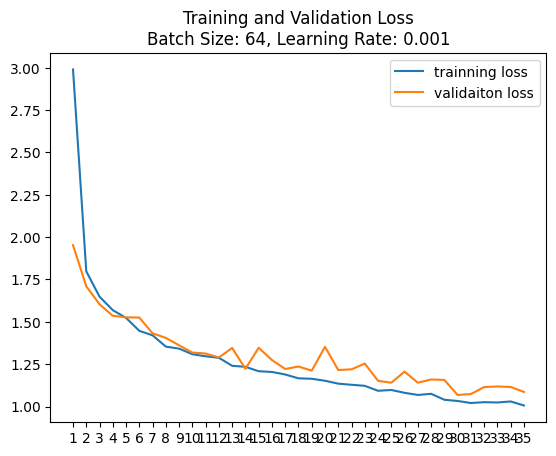

In [30]:
#Initialize model, optimizer
net = UrbanSoundNN()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
#Train and test model
train_loss, val_loss, model, epochs = train_model(net, optimizer, train_dl, val_dl)
test_model(model, test_dl)

#Plot the results
plt.plot(range(1, epochs + 1), train_loss, label='trainning loss')
plt.plot(range(1, epochs + 1), val_loss, label='validaiton loss')
plt.legend()
plt.xticks(range(1, epochs + 1))
plt.title(f'Training and Validation Loss\nBatch Size: {batch_size}, Learning Rate: {learning_rate}')
plt.show()

In [ ]:
#Optional grid search
def grid_search(learning_rates, batch_sizes):
    results = []
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Training with LR={lr}, Batch Size={batch_size}")
            
            # Update the DataLoader batch sizes
            learning_rate = learning_rates

            train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
            val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)
            test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)
            
            net1 = UrbanSoundNN()
            optimizer = torch.optim.SGD(net1.parameters(), lr=lr)
            train_loss, val_loss, model, epochs = train_model(net, optimizer, train_dl, val_dl)
            
            # Optionally, you can test the model here or after identifying the best hyperparameters
            # test_accuracy = test_model(trained_model, test_dl)
            
            # Plotting
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, epochs + 1), train_loss, label='Training loss')
            plt.plot(range(1, epochs + 1), val_loss, label='Validation loss')
            plt.legend()
            plt.xticks(range(1, epochs + 1))
            plt.title(f'Training and Validation Loss\nBatch Size: {batch_size}, Learning Rate: {lr}')
            plt.show()
            
            # Store results
            results.append((lr, batch_size, min(val_loss))) # Store the best (minimum) validation loss
    
    # Identify the best hyperparameters based on validation loss
    best_params = min(results, key=lambda x: x[2])
    print(f"Best Parameters: LR={best_params[0]}, Batch Size={best_params[1]} with Validation Loss={best_params[2]}")
    return best_params

# Define your search space
learning_rates = [0.0005, 0.001, 0.002, 0.003]
batch_sizes = [32, 64, 128] # Adjust based on your dataset and model complexity

# Run grid search, uncomment to run grid search
#best_params = grid_search(learning_rates, batch_sizes)

# Method 3: Convolutional Neural Networks

In [14]:
#CNN Model
class UrbanSoundCNN(nn.Module):
    def __init__(self):
        super(UrbanSoundCNN, self).__init__()
        
        # Convolutional layers
        # Input has 2 channels
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # input spectrogram size is [2, 64, 344] (channels, height, width)
        # After 1st conv+pool: [16, 32, 172]
        # After 2nd conv+pool: [32, 16, 86]
        # After 3rd conv+pool: [64, 8, 43]
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 43, 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10) 

        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        
        # Flattening the output for the fully connected layer
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with ReLU activation for hidden layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        # No activation function here, cross entropy loss to be applied
        x = self.fc3(x)  
        
        return x

In [15]:
def train_model(model, optimizer, train_loader, val_loader):
    #Also applied softmax with cross entropy loss
    criterion = torch.nn.CrossEntropyLoss()
    train_loss = []
    val_loss = []
    
    #Placeholder values
    val = float('inf')
    counter = 0
    moveOn = True
    epoch = 0
    #Condition to stop, only if moveON is false (Early Stopping COndition)
    while moveOn == True:
        # Loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0
        running_val_loss = 0.0
        running_val_acc = 0.0
        correct = 0
        total = 0
        model.train()
        for data in train_loader:
            inputs, labels = data
            # Zero the parameter gradients
            optimizer.zero_grad()  

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        running_acc = correct / total
        running_loss = running_loss / len(train_loader)
        
        correct = 0.0
        total = 0.0
        
        # model validation
        model.eval()
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                #Forward pass and validation loss
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                # Calculate validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        #Calculate running accuracy and losses
        running_val_acc = correct / total
        running_val_loss = running_val_loss / len(val_loader)
        train_loss.append(running_loss)
        val_loss.append(running_val_loss)
        # Print the loss, accuracy after each epoch
        print('[%d] loss: %.3f |  Val loss: %.3f | acc: %.2f  | Val acc: %.2f | ' % (epoch + 1, running_loss, running_val_loss, running_acc, running_val_acc))
        #increase epoch by 1
        epoch += 1
        
        #Early stopping condition, when loss does not decrease in 5 epochs
        if running_val_loss < val:
            val = running_val_loss
            counter = 0
        else:
            counter += 1
            if counter == 5:
                moveOn = False
        
            
    return train_loss, val_loss, model, epoch
#Test function
def test_model(model, test_loader):
    correct = 0
    total = 0
    #ensure model is not updated
    with torch.no_grad():
        #Loop through test data and calculate test loss and accuracy
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Testing accuracy is: %d %%' % (100 * correct / total))

In [16]:
# Update hyperparameters and variables(epochs, learning rate, batch size)
learning_rate = 0.001
batch_size = 64
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

[1] loss: 1.986 |  Val loss: 1.517 | acc: 0.31  | Val acc: 0.46 | 
[2] loss: 1.319 |  Val loss: 1.215 | acc: 0.54  | Val acc: 0.58 | 
[3] loss: 1.076 |  Val loss: 1.015 | acc: 0.62  | Val acc: 0.65 | 
[4] loss: 0.934 |  Val loss: 0.885 | acc: 0.68  | Val acc: 0.71 | 
[5] loss: 0.819 |  Val loss: 0.850 | acc: 0.72  | Val acc: 0.73 | 
[6] loss: 0.721 |  Val loss: 0.784 | acc: 0.75  | Val acc: 0.74 | 
[7] loss: 0.650 |  Val loss: 0.674 | acc: 0.78  | Val acc: 0.77 | 
[8] loss: 0.557 |  Val loss: 0.734 | acc: 0.81  | Val acc: 0.75 | 
[9] loss: 0.540 |  Val loss: 0.637 | acc: 0.81  | Val acc: 0.78 | 
[10] loss: 0.496 |  Val loss: 0.625 | acc: 0.83  | Val acc: 0.80 | 
[11] loss: 0.456 |  Val loss: 0.562 | acc: 0.85  | Val acc: 0.81 | 
[12] loss: 0.426 |  Val loss: 0.599 | acc: 0.85  | Val acc: 0.81 | 
[13] loss: 0.401 |  Val loss: 0.531 | acc: 0.86  | Val acc: 0.83 | 
[14] loss: 0.386 |  Val loss: 0.506 | acc: 0.86  | Val acc: 0.83 | 
[15] loss: 0.350 |  Val loss: 0.594 | acc: 0.88  | Val ac

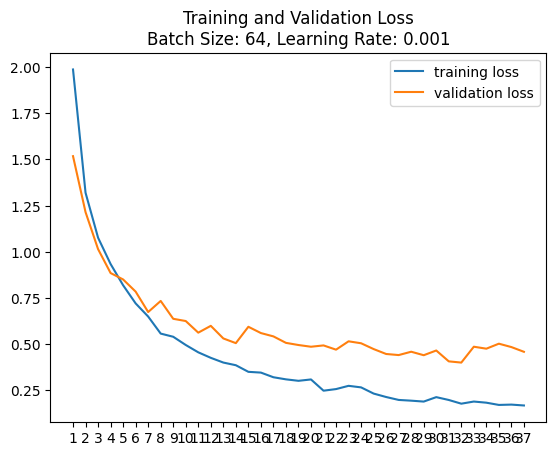

In [49]:
#Initialize Model and optimizer
net = UrbanSoundCNN()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
#Train and test the model
train_loss, val_loss, model, epochs = train_model(net, optimizer, train_dl, val_dl)
test_model(model, test_dl)

#Plot results
plt.plot(range(1, epochs + 1), train_loss, label='training loss')
plt.plot(range(1, epochs + 1), val_loss, label='validation loss')
plt.legend()
plt.xticks(range(1, epochs + 1))
plt.title(f'Training and Validation Loss\nBatch Size: {batch_size}, Learning Rate: {learning_rate}')
plt.show()

Running experiment with LR=0.001, Batch Size=32, Optimizer=Adam
[1] loss: 1.650 |  Val loss: 1.333 | acc: 0.42  | Val acc: 0.54 | 
[2] loss: 1.138 |  Val loss: 0.969 | acc: 0.61  | Val acc: 0.68 | 
[3] loss: 0.894 |  Val loss: 0.788 | acc: 0.69  | Val acc: 0.73 | 
[4] loss: 0.753 |  Val loss: 0.736 | acc: 0.74  | Val acc: 0.74 | 
[5] loss: 0.675 |  Val loss: 0.822 | acc: 0.77  | Val acc: 0.74 | 
[6] loss: 0.607 |  Val loss: 0.667 | acc: 0.79  | Val acc: 0.77 | 
[7] loss: 0.540 |  Val loss: 0.613 | acc: 0.81  | Val acc: 0.80 | 
[8] loss: 0.476 |  Val loss: 0.554 | acc: 0.84  | Val acc: 0.82 | 
[9] loss: 0.460 |  Val loss: 0.600 | acc: 0.84  | Val acc: 0.79 | 
[10] loss: 0.423 |  Val loss: 0.515 | acc: 0.86  | Val acc: 0.82 | 
[11] loss: 0.394 |  Val loss: 0.513 | acc: 0.86  | Val acc: 0.84 | 
[12] loss: 0.350 |  Val loss: 0.453 | acc: 0.88  | Val acc: 0.85 | 
[13] loss: 0.334 |  Val loss: 0.493 | acc: 0.89  | Val acc: 0.85 | 
[14] loss: 0.364 |  Val loss: 0.440 | acc: 0.88  | Val acc: 0

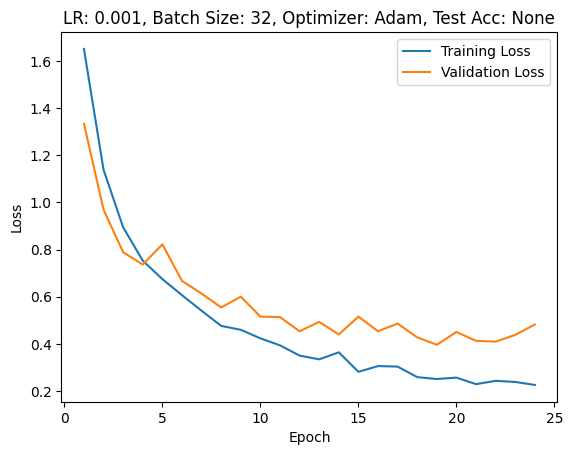

Running experiment with LR=0.001, Batch Size=64, Optimizer=Adam
[1] loss: 1.975 |  Val loss: 1.457 | acc: 0.31  | Val acc: 0.45 | 
[2] loss: 1.311 |  Val loss: 1.184 | acc: 0.54  | Val acc: 0.58 | 
[3] loss: 1.106 |  Val loss: 1.080 | acc: 0.62  | Val acc: 0.63 | 
[4] loss: 0.943 |  Val loss: 0.932 | acc: 0.68  | Val acc: 0.68 | 
[5] loss: 0.831 |  Val loss: 0.807 | acc: 0.72  | Val acc: 0.72 | 
[6] loss: 0.736 |  Val loss: 0.745 | acc: 0.75  | Val acc: 0.73 | 
[7] loss: 0.677 |  Val loss: 0.671 | acc: 0.76  | Val acc: 0.78 | 
[8] loss: 0.606 |  Val loss: 0.680 | acc: 0.79  | Val acc: 0.78 | 
[9] loss: 0.545 |  Val loss: 0.639 | acc: 0.82  | Val acc: 0.78 | 
[10] loss: 0.508 |  Val loss: 0.632 | acc: 0.82  | Val acc: 0.78 | 
[11] loss: 0.474 |  Val loss: 0.579 | acc: 0.84  | Val acc: 0.81 | 
[12] loss: 0.419 |  Val loss: 0.526 | acc: 0.86  | Val acc: 0.82 | 
[13] loss: 0.380 |  Val loss: 0.531 | acc: 0.86  | Val acc: 0.82 | 
[14] loss: 0.380 |  Val loss: 0.500 | acc: 0.87  | Val acc: 0

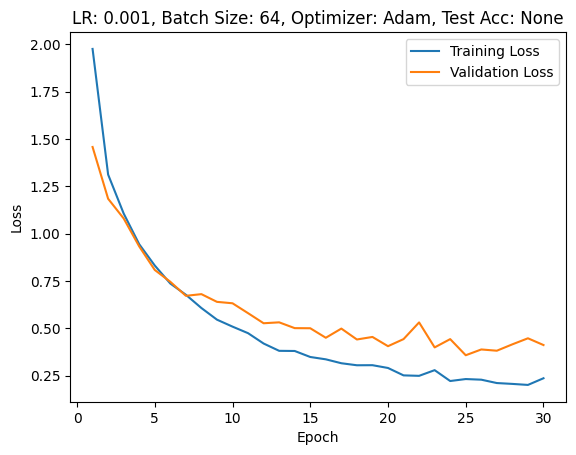

Running experiment with LR=0.001, Batch Size=128, Optimizer=Adam
[1] loss: 2.442 |  Val loss: 1.740 | acc: 0.23  | Val acc: 0.36 | 
[2] loss: 1.620 |  Val loss: 1.487 | acc: 0.41  | Val acc: 0.46 | 
[3] loss: 1.365 |  Val loss: 1.192 | acc: 0.53  | Val acc: 0.60 | 
[4] loss: 1.186 |  Val loss: 1.126 | acc: 0.59  | Val acc: 0.61 | 
[5] loss: 1.059 |  Val loss: 1.012 | acc: 0.63  | Val acc: 0.65 | 
[6] loss: 0.964 |  Val loss: 0.935 | acc: 0.67  | Val acc: 0.67 | 
[7] loss: 0.922 |  Val loss: 0.873 | acc: 0.68  | Val acc: 0.69 | 
[8] loss: 0.798 |  Val loss: 0.807 | acc: 0.72  | Val acc: 0.73 | 
[9] loss: 0.772 |  Val loss: 0.768 | acc: 0.74  | Val acc: 0.75 | 
[10] loss: 0.705 |  Val loss: 0.680 | acc: 0.76  | Val acc: 0.77 | 
[11] loss: 0.686 |  Val loss: 0.683 | acc: 0.77  | Val acc: 0.77 | 
[12] loss: 0.594 |  Val loss: 0.655 | acc: 0.80  | Val acc: 0.78 | 
[13] loss: 0.599 |  Val loss: 0.642 | acc: 0.80  | Val acc: 0.79 | 
[14] loss: 0.560 |  Val loss: 0.610 | acc: 0.82  | Val acc: 

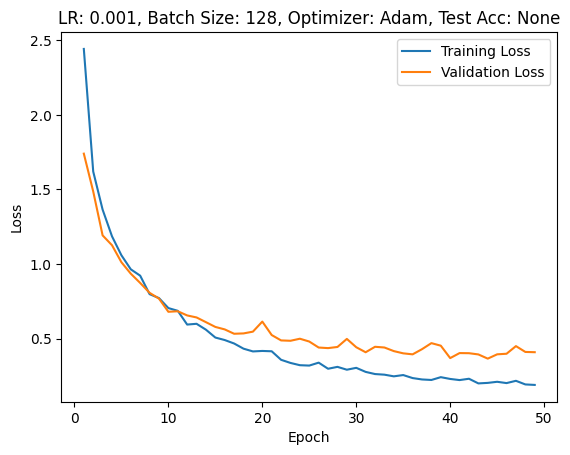

Running experiment with LR=0.0005, Batch Size=32, Optimizer=Adam
[1] loss: 1.782 |  Val loss: 1.346 | acc: 0.37  | Val acc: 0.54 | 
[2] loss: 1.242 |  Val loss: 1.053 | acc: 0.58  | Val acc: 0.65 | 
[3] loss: 1.000 |  Val loss: 0.927 | acc: 0.65  | Val acc: 0.70 | 
[4] loss: 0.847 |  Val loss: 0.934 | acc: 0.71  | Val acc: 0.68 | 
[5] loss: 0.746 |  Val loss: 0.719 | acc: 0.75  | Val acc: 0.77 | 
[6] loss: 0.629 |  Val loss: 0.706 | acc: 0.79  | Val acc: 0.74 | 
[7] loss: 0.572 |  Val loss: 0.565 | acc: 0.80  | Val acc: 0.81 | 
[8] loss: 0.512 |  Val loss: 0.533 | acc: 0.82  | Val acc: 0.83 | 
[9] loss: 0.483 |  Val loss: 0.534 | acc: 0.84  | Val acc: 0.82 | 
[10] loss: 0.433 |  Val loss: 0.511 | acc: 0.85  | Val acc: 0.82 | 
[11] loss: 0.391 |  Val loss: 0.468 | acc: 0.87  | Val acc: 0.84 | 
[12] loss: 0.387 |  Val loss: 0.452 | acc: 0.87  | Val acc: 0.84 | 
[13] loss: 0.344 |  Val loss: 0.514 | acc: 0.88  | Val acc: 0.84 | 
[14] loss: 0.346 |  Val loss: 0.423 | acc: 0.88  | Val acc: 

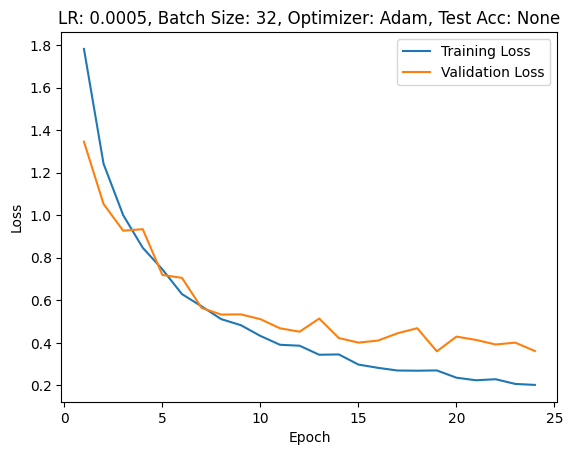

Running experiment with LR=0.0005, Batch Size=64, Optimizer=Adam
[1] loss: 1.921 |  Val loss: 1.470 | acc: 0.35  | Val acc: 0.48 | 
[2] loss: 1.320 |  Val loss: 1.201 | acc: 0.54  | Val acc: 0.59 | 
[3] loss: 1.083 |  Val loss: 1.055 | acc: 0.63  | Val acc: 0.64 | 
[4] loss: 0.918 |  Val loss: 0.912 | acc: 0.68  | Val acc: 0.68 | 
[5] loss: 0.840 |  Val loss: 0.806 | acc: 0.72  | Val acc: 0.72 | 
[6] loss: 0.728 |  Val loss: 0.758 | acc: 0.75  | Val acc: 0.73 | 
[7] loss: 0.658 |  Val loss: 0.700 | acc: 0.78  | Val acc: 0.76 | 
[8] loss: 0.604 |  Val loss: 0.681 | acc: 0.79  | Val acc: 0.77 | 
[9] loss: 0.581 |  Val loss: 0.656 | acc: 0.80  | Val acc: 0.78 | 
[10] loss: 0.519 |  Val loss: 0.578 | acc: 0.83  | Val acc: 0.81 | 
[11] loss: 0.471 |  Val loss: 0.592 | acc: 0.84  | Val acc: 0.81 | 
[12] loss: 0.484 |  Val loss: 0.550 | acc: 0.83  | Val acc: 0.82 | 
[13] loss: 0.415 |  Val loss: 0.499 | acc: 0.85  | Val acc: 0.83 | 
[14] loss: 0.426 |  Val loss: 0.526 | acc: 0.85  | Val acc: 

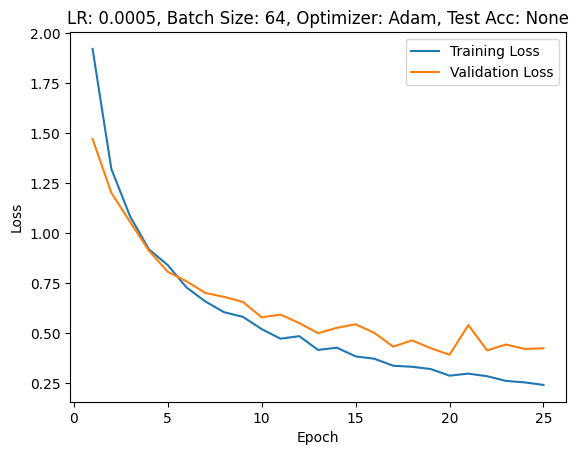

Running experiment with LR=0.0005, Batch Size=128, Optimizer=Adam
[1] loss: 1.822 |  Val loss: 1.455 | acc: 0.33  | Val acc: 0.44 | 
[2] loss: 1.321 |  Val loss: 1.184 | acc: 0.53  | Val acc: 0.57 | 
[3] loss: 1.115 |  Val loss: 1.074 | acc: 0.61  | Val acc: 0.62 | 
[4] loss: 0.980 |  Val loss: 0.887 | acc: 0.67  | Val acc: 0.71 | 
[5] loss: 0.849 |  Val loss: 0.898 | acc: 0.71  | Val acc: 0.70 | 
[6] loss: 0.782 |  Val loss: 0.771 | acc: 0.73  | Val acc: 0.75 | 
[7] loss: 0.731 |  Val loss: 0.737 | acc: 0.75  | Val acc: 0.75 | 
[8] loss: 0.645 |  Val loss: 0.672 | acc: 0.77  | Val acc: 0.77 | 
[9] loss: 0.571 |  Val loss: 0.673 | acc: 0.81  | Val acc: 0.78 | 
[10] loss: 0.543 |  Val loss: 0.577 | acc: 0.82  | Val acc: 0.81 | 
[11] loss: 0.495 |  Val loss: 0.591 | acc: 0.84  | Val acc: 0.80 | 
[12] loss: 0.469 |  Val loss: 0.557 | acc: 0.84  | Val acc: 0.81 | 
[13] loss: 0.428 |  Val loss: 0.477 | acc: 0.86  | Val acc: 0.84 | 
[14] loss: 0.413 |  Val loss: 0.548 | acc: 0.85  | Val acc:

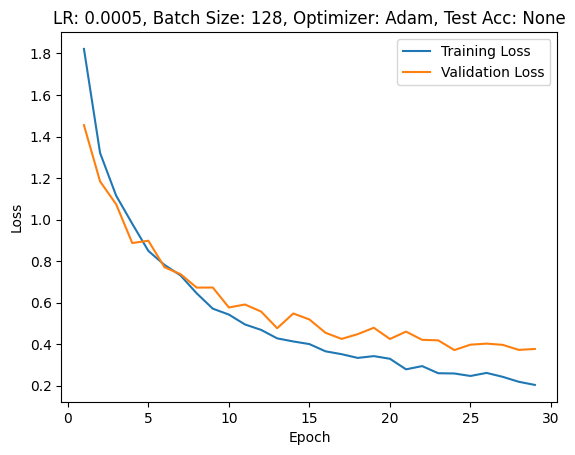

Running experiment with LR=0.0001, Batch Size=32, Optimizer=Adam
[1] loss: 1.843 |  Val loss: 1.544 | acc: 0.33  | Val acc: 0.45 | 
[2] loss: 1.408 |  Val loss: 1.300 | acc: 0.51  | Val acc: 0.54 | 
[3] loss: 1.239 |  Val loss: 1.163 | acc: 0.58  | Val acc: 0.58 | 
[4] loss: 1.125 |  Val loss: 1.154 | acc: 0.61  | Val acc: 0.58 | 
[5] loss: 1.053 |  Val loss: 0.985 | acc: 0.63  | Val acc: 0.66 | 
[6] loss: 0.974 |  Val loss: 1.013 | acc: 0.67  | Val acc: 0.65 | 
[7] loss: 0.914 |  Val loss: 0.951 | acc: 0.68  | Val acc: 0.65 | 
[8] loss: 0.866 |  Val loss: 0.856 | acc: 0.70  | Val acc: 0.71 | 
[9] loss: 0.811 |  Val loss: 0.812 | acc: 0.72  | Val acc: 0.71 | 
[10] loss: 0.770 |  Val loss: 0.809 | acc: 0.74  | Val acc: 0.73 | 
[11] loss: 0.744 |  Val loss: 0.762 | acc: 0.75  | Val acc: 0.73 | 
[12] loss: 0.709 |  Val loss: 0.762 | acc: 0.76  | Val acc: 0.74 | 
[13] loss: 0.680 |  Val loss: 0.704 | acc: 0.77  | Val acc: 0.77 | 
[14] loss: 0.683 |  Val loss: 0.677 | acc: 0.77  | Val acc: 

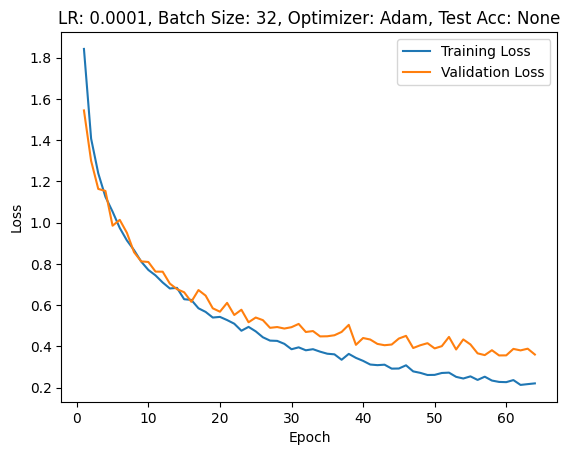

Running experiment with LR=0.0001, Batch Size=64, Optimizer=Adam
[1] loss: 1.862 |  Val loss: 1.571 | acc: 0.33  | Val acc: 0.43 | 
[2] loss: 1.462 |  Val loss: 1.368 | acc: 0.48  | Val acc: 0.54 | 
[3] loss: 1.285 |  Val loss: 1.213 | acc: 0.57  | Val acc: 0.58 | 
[4] loss: 1.191 |  Val loss: 1.170 | acc: 0.59  | Val acc: 0.59 | 
[5] loss: 1.121 |  Val loss: 1.102 | acc: 0.61  | Val acc: 0.61 | 
[6] loss: 1.058 |  Val loss: 1.059 | acc: 0.64  | Val acc: 0.63 | 
[7] loss: 0.987 |  Val loss: 0.939 | acc: 0.67  | Val acc: 0.69 | 
[8] loss: 0.927 |  Val loss: 0.915 | acc: 0.69  | Val acc: 0.69 | 
[9] loss: 0.903 |  Val loss: 0.878 | acc: 0.69  | Val acc: 0.71 | 
[10] loss: 0.858 |  Val loss: 0.823 | acc: 0.71  | Val acc: 0.71 | 
[11] loss: 0.816 |  Val loss: 0.873 | acc: 0.72  | Val acc: 0.71 | 
[12] loss: 0.792 |  Val loss: 0.780 | acc: 0.74  | Val acc: 0.73 | 
[13] loss: 0.747 |  Val loss: 0.767 | acc: 0.75  | Val acc: 0.73 | 
[14] loss: 0.727 |  Val loss: 0.755 | acc: 0.75  | Val acc: 

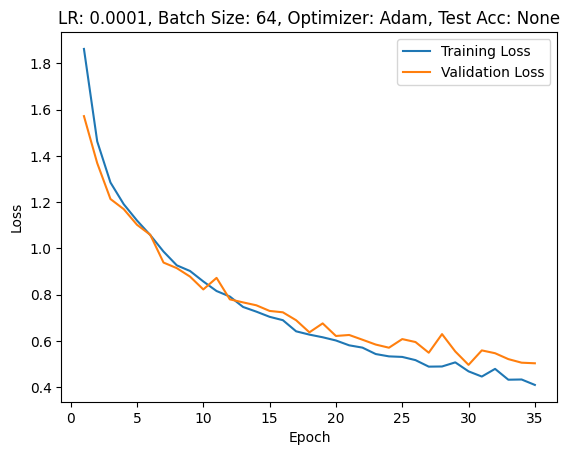

Running experiment with LR=0.0001, Batch Size=128, Optimizer=Adam
[1] loss: 1.880 |  Val loss: 1.604 | acc: 0.33  | Val acc: 0.42 | 
[2] loss: 1.513 |  Val loss: 1.386 | acc: 0.47  | Val acc: 0.51 | 
[3] loss: 1.332 |  Val loss: 1.306 | acc: 0.53  | Val acc: 0.52 | 
[4] loss: 1.234 |  Val loss: 1.208 | acc: 0.57  | Val acc: 0.56 | 
[5] loss: 1.169 |  Val loss: 1.141 | acc: 0.60  | Val acc: 0.60 | 
[6] loss: 1.095 |  Val loss: 1.048 | acc: 0.62  | Val acc: 0.64 | 
[7] loss: 1.039 |  Val loss: 1.049 | acc: 0.65  | Val acc: 0.65 | 
[8] loss: 0.977 |  Val loss: 1.009 | acc: 0.67  | Val acc: 0.64 | 
[9] loss: 0.946 |  Val loss: 0.936 | acc: 0.68  | Val acc: 0.68 | 
[10] loss: 0.897 |  Val loss: 0.906 | acc: 0.69  | Val acc: 0.70 | 
[11] loss: 0.884 |  Val loss: 0.856 | acc: 0.69  | Val acc: 0.71 | 
[12] loss: 0.824 |  Val loss: 0.847 | acc: 0.72  | Val acc: 0.72 | 
[13] loss: 0.802 |  Val loss: 0.812 | acc: 0.72  | Val acc: 0.71 | 
[14] loss: 0.767 |  Val loss: 0.798 | acc: 0.74  | Val acc:

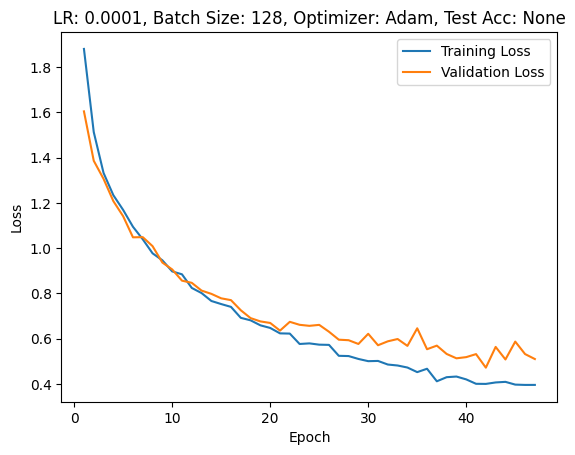

Running experiment with LR=0.001, Batch Size=32, Optimizer=SGD
[1] loss: 1.860 |  Val loss: 1.618 | acc: 0.32  | Val acc: 0.40 | 
[2] loss: 1.493 |  Val loss: 1.353 | acc: 0.45  | Val acc: 0.52 | 
[3] loss: 1.292 |  Val loss: 1.302 | acc: 0.54  | Val acc: 0.54 | 
[4] loss: 1.165 |  Val loss: 1.083 | acc: 0.59  | Val acc: 0.62 | 
[5] loss: 1.039 |  Val loss: 0.962 | acc: 0.64  | Val acc: 0.66 | 
[6] loss: 0.933 |  Val loss: 0.912 | acc: 0.68  | Val acc: 0.67 | 
[7] loss: 0.873 |  Val loss: 0.877 | acc: 0.69  | Val acc: 0.69 | 
[8] loss: 0.821 |  Val loss: 0.910 | acc: 0.72  | Val acc: 0.67 | 
[9] loss: 0.771 |  Val loss: 0.720 | acc: 0.73  | Val acc: 0.76 | 
[10] loss: 0.688 |  Val loss: 0.733 | acc: 0.76  | Val acc: 0.76 | 
[11] loss: 0.645 |  Val loss: 0.682 | acc: 0.78  | Val acc: 0.76 | 
[12] loss: 0.594 |  Val loss: 0.615 | acc: 0.79  | Val acc: 0.79 | 
[13] loss: 0.554 |  Val loss: 0.562 | acc: 0.81  | Val acc: 0.81 | 
[14] loss: 0.523 |  Val loss: 0.635 | acc: 0.82  | Val acc: 0.

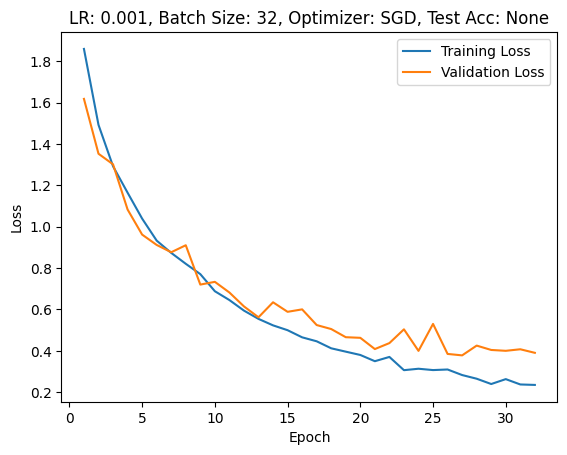

Running experiment with LR=0.001, Batch Size=64, Optimizer=SGD
[1] loss: 1.902 |  Val loss: 1.665 | acc: 0.31  | Val acc: 0.38 | 
[2] loss: 1.533 |  Val loss: 1.421 | acc: 0.45  | Val acc: 0.48 | 
[3] loss: 1.397 |  Val loss: 1.291 | acc: 0.49  | Val acc: 0.54 | 
[4] loss: 1.264 |  Val loss: 1.198 | acc: 0.55  | Val acc: 0.57 | 
[5] loss: 1.163 |  Val loss: 1.082 | acc: 0.60  | Val acc: 0.62 | 
[6] loss: 1.057 |  Val loss: 1.111 | acc: 0.63  | Val acc: 0.61 | 
[7] loss: 0.982 |  Val loss: 0.976 | acc: 0.66  | Val acc: 0.66 | 
[8] loss: 0.912 |  Val loss: 0.935 | acc: 0.69  | Val acc: 0.69 | 
[9] loss: 0.872 |  Val loss: 0.872 | acc: 0.70  | Val acc: 0.69 | 
[10] loss: 0.810 |  Val loss: 0.798 | acc: 0.72  | Val acc: 0.73 | 
[11] loss: 0.752 |  Val loss: 0.841 | acc: 0.74  | Val acc: 0.71 | 
[12] loss: 0.743 |  Val loss: 0.768 | acc: 0.74  | Val acc: 0.75 | 
[13] loss: 0.694 |  Val loss: 0.869 | acc: 0.78  | Val acc: 0.71 | 
[14] loss: 0.651 |  Val loss: 0.702 | acc: 0.78  | Val acc: 0.

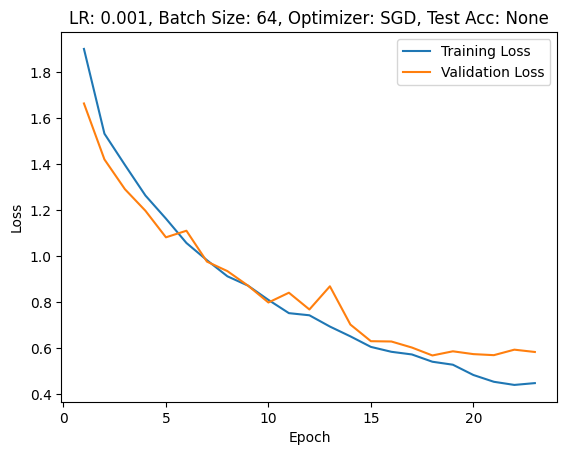

Running experiment with LR=0.001, Batch Size=128, Optimizer=SGD
[1] loss: 1.970 |  Val loss: 1.731 | acc: 0.28  | Val acc: 0.36 | 
[2] loss: 1.630 |  Val loss: 1.506 | acc: 0.41  | Val acc: 0.45 | 
[3] loss: 1.477 |  Val loss: 1.437 | acc: 0.48  | Val acc: 0.47 | 
[4] loss: 1.398 |  Val loss: 1.338 | acc: 0.50  | Val acc: 0.53 | 
[5] loss: 1.321 |  Val loss: 1.278 | acc: 0.54  | Val acc: 0.54 | 
[6] loss: 1.281 |  Val loss: 1.217 | acc: 0.55  | Val acc: 0.58 | 
[7] loss: 1.189 |  Val loss: 1.146 | acc: 0.59  | Val acc: 0.60 | 
[8] loss: 1.142 |  Val loss: 1.187 | acc: 0.60  | Val acc: 0.59 | 
[9] loss: 1.094 |  Val loss: 1.033 | acc: 0.62  | Val acc: 0.66 | 
[10] loss: 1.054 |  Val loss: 1.051 | acc: 0.63  | Val acc: 0.64 | 
[11] loss: 0.980 |  Val loss: 0.966 | acc: 0.66  | Val acc: 0.67 | 
[12] loss: 0.949 |  Val loss: 0.923 | acc: 0.67  | Val acc: 0.69 | 
[13] loss: 0.908 |  Val loss: 0.934 | acc: 0.69  | Val acc: 0.68 | 
[14] loss: 0.850 |  Val loss: 0.857 | acc: 0.71  | Val acc: 0

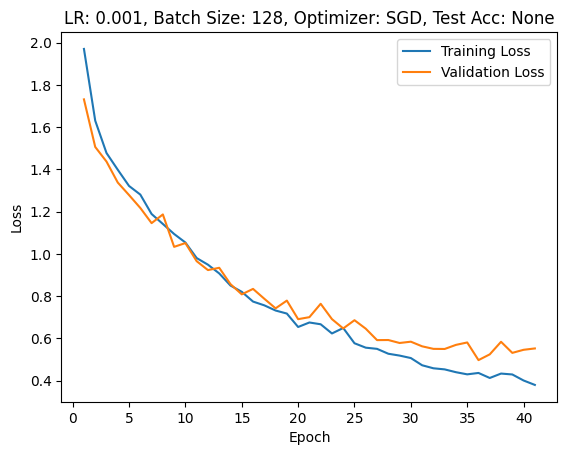

Running experiment with LR=0.0005, Batch Size=32, Optimizer=SGD
[1] loss: 1.878 |  Val loss: 1.594 | acc: 0.32  | Val acc: 0.42 | 
[2] loss: 1.525 |  Val loss: 1.446 | acc: 0.45  | Val acc: 0.49 | 
[3] loss: 1.373 |  Val loss: 1.296 | acc: 0.52  | Val acc: 0.52 | 
[4] loss: 1.260 |  Val loss: 1.182 | acc: 0.56  | Val acc: 0.59 | 
[5] loss: 1.176 |  Val loss: 1.116 | acc: 0.59  | Val acc: 0.61 | 
[6] loss: 1.069 |  Val loss: 0.998 | acc: 0.63  | Val acc: 0.67 | 
[7] loss: 0.987 |  Val loss: 0.960 | acc: 0.65  | Val acc: 0.67 | 
[8] loss: 0.926 |  Val loss: 0.908 | acc: 0.68  | Val acc: 0.68 | 
[9] loss: 0.856 |  Val loss: 0.848 | acc: 0.70  | Val acc: 0.71 | 
[10] loss: 0.799 |  Val loss: 0.820 | acc: 0.73  | Val acc: 0.73 | 
[11] loss: 0.742 |  Val loss: 0.831 | acc: 0.75  | Val acc: 0.72 | 
[12] loss: 0.720 |  Val loss: 0.748 | acc: 0.75  | Val acc: 0.74 | 
[13] loss: 0.694 |  Val loss: 0.789 | acc: 0.76  | Val acc: 0.73 | 
[14] loss: 0.656 |  Val loss: 0.717 | acc: 0.77  | Val acc: 0

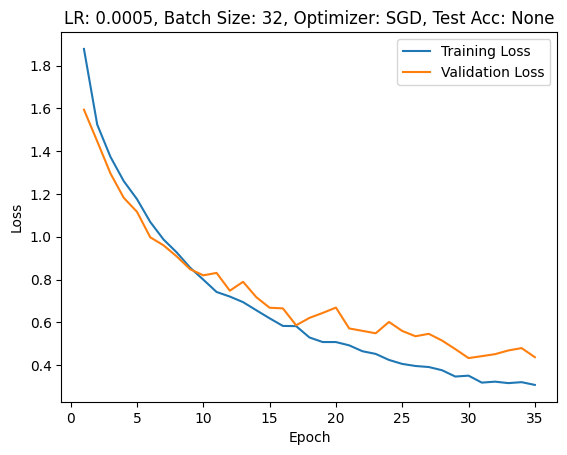

Running experiment with LR=0.0005, Batch Size=64, Optimizer=SGD
[1] loss: 1.993 |  Val loss: 1.748 | acc: 0.28  | Val acc: 0.38 | 
[2] loss: 1.669 |  Val loss: 1.642 | acc: 0.39  | Val acc: 0.40 | 
[3] loss: 1.537 |  Val loss: 1.498 | acc: 0.45  | Val acc: 0.45 | 
[4] loss: 1.424 |  Val loss: 1.396 | acc: 0.50  | Val acc: 0.50 | 
[5] loss: 1.343 |  Val loss: 1.343 | acc: 0.53  | Val acc: 0.50 | 
[6] loss: 1.274 |  Val loss: 1.200 | acc: 0.55  | Val acc: 0.58 | 
[7] loss: 1.196 |  Val loss: 1.136 | acc: 0.58  | Val acc: 0.61 | 
[8] loss: 1.126 |  Val loss: 1.079 | acc: 0.61  | Val acc: 0.62 | 
[9] loss: 1.060 |  Val loss: 1.053 | acc: 0.64  | Val acc: 0.64 | 
[10] loss: 1.020 |  Val loss: 1.003 | acc: 0.64  | Val acc: 0.65 | 
[11] loss: 0.994 |  Val loss: 0.984 | acc: 0.66  | Val acc: 0.65 | 
[12] loss: 0.930 |  Val loss: 0.900 | acc: 0.68  | Val acc: 0.68 | 
[13] loss: 0.877 |  Val loss: 0.944 | acc: 0.70  | Val acc: 0.67 | 
[14] loss: 0.850 |  Val loss: 1.010 | acc: 0.71  | Val acc: 0

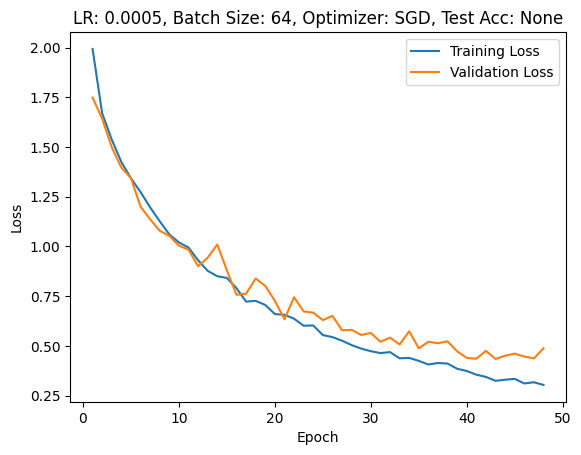

Running experiment with LR=0.0005, Batch Size=128, Optimizer=SGD
[1] loss: 2.155 |  Val loss: 2.018 | acc: 0.22  | Val acc: 0.24 | 
[2] loss: 1.913 |  Val loss: 1.859 | acc: 0.29  | Val acc: 0.31 | 
[3] loss: 1.780 |  Val loss: 1.704 | acc: 0.35  | Val acc: 0.37 | 
[4] loss: 1.653 |  Val loss: 1.592 | acc: 0.39  | Val acc: 0.43 | 
[5] loss: 1.610 |  Val loss: 1.548 | acc: 0.41  | Val acc: 0.42 | 
[6] loss: 1.547 |  Val loss: 1.476 | acc: 0.44  | Val acc: 0.45 | 
[7] loss: 1.474 |  Val loss: 1.401 | acc: 0.47  | Val acc: 0.46 | 
[8] loss: 1.404 |  Val loss: 1.335 | acc: 0.50  | Val acc: 0.51 | 
[9] loss: 1.358 |  Val loss: 1.337 | acc: 0.52  | Val acc: 0.50 | 
[10] loss: 1.312 |  Val loss: 1.260 | acc: 0.53  | Val acc: 0.52 | 
[11] loss: 1.273 |  Val loss: 1.281 | acc: 0.55  | Val acc: 0.54 | 
[12] loss: 1.231 |  Val loss: 1.235 | acc: 0.57  | Val acc: 0.55 | 
[13] loss: 1.180 |  Val loss: 1.181 | acc: 0.59  | Val acc: 0.58 | 
[14] loss: 1.178 |  Val loss: 1.134 | acc: 0.59  | Val acc: 

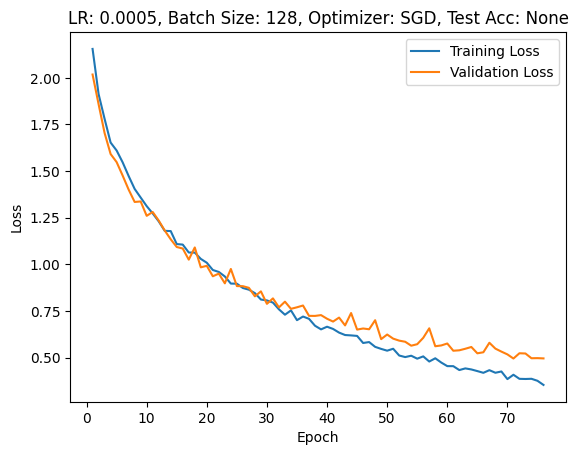

Running experiment with LR=0.0001, Batch Size=32, Optimizer=SGD
[1] loss: 2.108 |  Val loss: 1.953 | acc: 0.25  | Val acc: 0.32 | 
[2] loss: 1.836 |  Val loss: 1.770 | acc: 0.34  | Val acc: 0.35 | 
[3] loss: 1.699 |  Val loss: 1.618 | acc: 0.39  | Val acc: 0.43 | 
[4] loss: 1.591 |  Val loss: 1.528 | acc: 0.43  | Val acc: 0.44 | 
[5] loss: 1.515 |  Val loss: 1.464 | acc: 0.46  | Val acc: 0.47 | 
[6] loss: 1.454 |  Val loss: 1.383 | acc: 0.48  | Val acc: 0.51 | 
[7] loss: 1.392 |  Val loss: 1.362 | acc: 0.51  | Val acc: 0.50 | 
[8] loss: 1.357 |  Val loss: 1.332 | acc: 0.52  | Val acc: 0.50 | 
[9] loss: 1.296 |  Val loss: 1.234 | acc: 0.54  | Val acc: 0.57 | 
[10] loss: 1.238 |  Val loss: 1.224 | acc: 0.57  | Val acc: 0.58 | 
[11] loss: 1.207 |  Val loss: 1.161 | acc: 0.58  | Val acc: 0.60 | 
[12] loss: 1.178 |  Val loss: 1.118 | acc: 0.59  | Val acc: 0.60 | 
[13] loss: 1.134 |  Val loss: 1.147 | acc: 0.61  | Val acc: 0.59 | 
[14] loss: 1.119 |  Val loss: 1.130 | acc: 0.61  | Val acc: 0

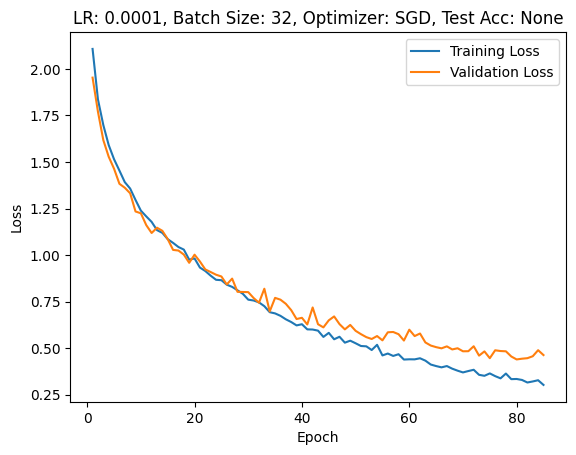

Running experiment with LR=0.0001, Batch Size=64, Optimizer=SGD
[1] loss: 2.210 |  Val loss: 2.129 | acc: 0.20  | Val acc: 0.25 | 
[2] loss: 2.049 |  Val loss: 1.985 | acc: 0.28  | Val acc: 0.28 | 
[3] loss: 1.913 |  Val loss: 1.815 | acc: 0.31  | Val acc: 0.33 | 
[4] loss: 1.785 |  Val loss: 1.725 | acc: 0.35  | Val acc: 0.34 | 
[5] loss: 1.689 |  Val loss: 1.629 | acc: 0.38  | Val acc: 0.40 | 
[6] loss: 1.639 |  Val loss: 1.552 | acc: 0.40  | Val acc: 0.44 | 
[7] loss: 1.580 |  Val loss: 1.545 | acc: 0.43  | Val acc: 0.44 | 
[8] loss: 1.544 |  Val loss: 1.494 | acc: 0.45  | Val acc: 0.45 | 
[9] loss: 1.505 |  Val loss: 1.456 | acc: 0.45  | Val acc: 0.47 | 
[10] loss: 1.475 |  Val loss: 1.418 | acc: 0.47  | Val acc: 0.47 | 
[11] loss: 1.440 |  Val loss: 1.433 | acc: 0.49  | Val acc: 0.48 | 
[12] loss: 1.414 |  Val loss: 1.415 | acc: 0.50  | Val acc: 0.49 | 
[13] loss: 1.402 |  Val loss: 1.356 | acc: 0.50  | Val acc: 0.51 | 
[14] loss: 1.366 |  Val loss: 1.346 | acc: 0.51  | Val acc: 0

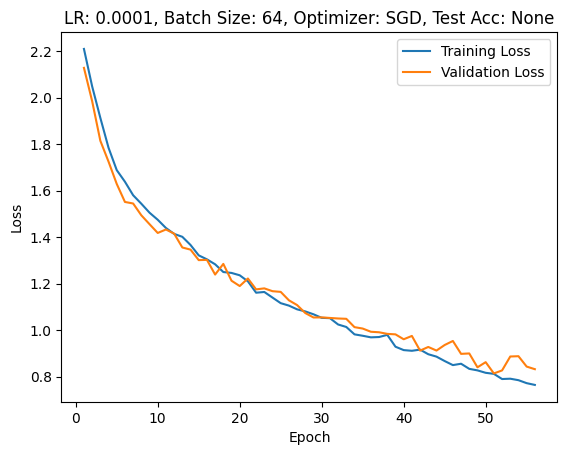

Running experiment with LR=0.0001, Batch Size=128, Optimizer=SGD
[1] loss: 2.271 |  Val loss: 2.219 | acc: 0.17  | Val acc: 0.23 | 
[2] loss: 2.177 |  Val loss: 2.128 | acc: 0.23  | Val acc: 0.25 | 
[3] loss: 2.087 |  Val loss: 2.046 | acc: 0.26  | Val acc: 0.25 | 
[4] loss: 1.999 |  Val loss: 1.954 | acc: 0.29  | Val acc: 0.30 | 
[5] loss: 1.924 |  Val loss: 1.870 | acc: 0.31  | Val acc: 0.34 | 
[6] loss: 1.855 |  Val loss: 1.828 | acc: 0.34  | Val acc: 0.36 | 
[7] loss: 1.809 |  Val loss: 1.755 | acc: 0.36  | Val acc: 0.39 | 
[8] loss: 1.763 |  Val loss: 1.710 | acc: 0.37  | Val acc: 0.38 | 
[9] loss: 1.727 |  Val loss: 1.676 | acc: 0.38  | Val acc: 0.40 | 
[10] loss: 1.682 |  Val loss: 1.659 | acc: 0.39  | Val acc: 0.40 | 
[11] loss: 1.658 |  Val loss: 1.618 | acc: 0.39  | Val acc: 0.41 | 
[12] loss: 1.627 |  Val loss: 1.590 | acc: 0.41  | Val acc: 0.40 | 
[13] loss: 1.598 |  Val loss: 1.557 | acc: 0.42  | Val acc: 0.42 | 
[14] loss: 1.574 |  Val loss: 1.511 | acc: 0.43  | Val acc: 

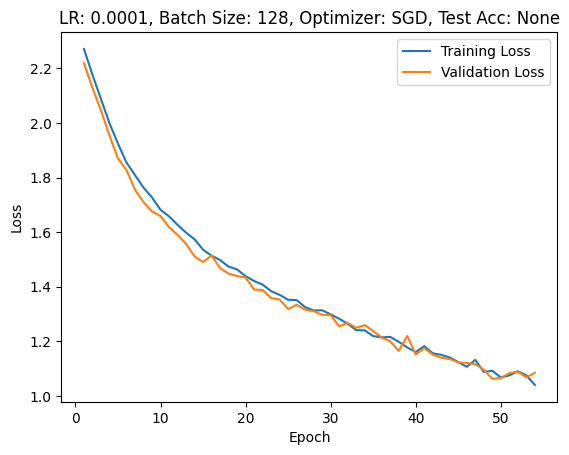

Running experiment with LR=0.001, Batch Size=32, Optimizer=RMSprop
[1] loss: 3.895 |  Val loss: 1.476 | acc: 0.33  | Val acc: 0.46 | 
[2] loss: 1.387 |  Val loss: 1.248 | acc: 0.51  | Val acc: 0.57 | 
[3] loss: 1.198 |  Val loss: 1.076 | acc: 0.59  | Val acc: 0.62 | 
[4] loss: 1.029 |  Val loss: 0.941 | acc: 0.64  | Val acc: 0.68 | 
[5] loss: 0.933 |  Val loss: 0.839 | acc: 0.69  | Val acc: 0.72 | 
[6] loss: 0.782 |  Val loss: 0.850 | acc: 0.73  | Val acc: 0.70 | 
[7] loss: 0.707 |  Val loss: 0.853 | acc: 0.76  | Val acc: 0.73 | 
[8] loss: 0.642 |  Val loss: 0.732 | acc: 0.79  | Val acc: 0.75 | 
[9] loss: 0.578 |  Val loss: 0.602 | acc: 0.80  | Val acc: 0.80 | 
[10] loss: 0.517 |  Val loss: 0.566 | acc: 0.82  | Val acc: 0.82 | 
[11] loss: 0.492 |  Val loss: 0.733 | acc: 0.83  | Val acc: 0.76 | 
[12] loss: 0.455 |  Val loss: 0.639 | acc: 0.85  | Val acc: 0.79 | 
[13] loss: 0.409 |  Val loss: 0.514 | acc: 0.86  | Val acc: 0.84 | 
[14] loss: 0.397 |  Val loss: 0.916 | acc: 0.87  | Val acc

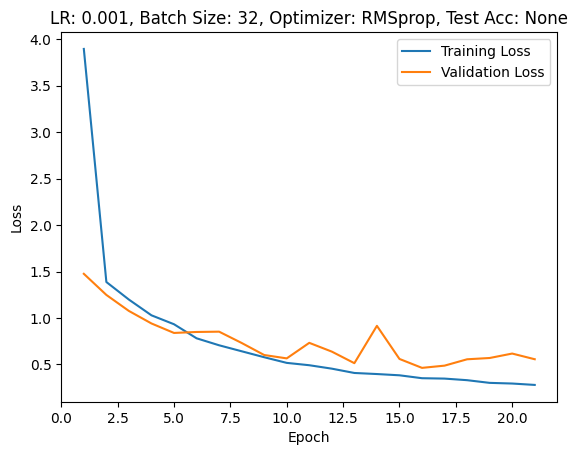

Running experiment with LR=0.001, Batch Size=64, Optimizer=RMSprop
[1] loss: 3.529 |  Val loss: 1.619 | acc: 0.32  | Val acc: 0.41 | 
[2] loss: 1.366 |  Val loss: 1.191 | acc: 0.51  | Val acc: 0.60 | 
[3] loss: 1.152 |  Val loss: 1.182 | acc: 0.60  | Val acc: 0.57 | 
[4] loss: 0.996 |  Val loss: 0.945 | acc: 0.66  | Val acc: 0.68 | 
[5] loss: 0.882 |  Val loss: 0.894 | acc: 0.70  | Val acc: 0.70 | 
[6] loss: 0.796 |  Val loss: 0.877 | acc: 0.73  | Val acc: 0.70 | 
[7] loss: 0.739 |  Val loss: 0.789 | acc: 0.74  | Val acc: 0.73 | 
[8] loss: 0.663 |  Val loss: 0.844 | acc: 0.77  | Val acc: 0.72 | 
[9] loss: 0.588 |  Val loss: 0.578 | acc: 0.80  | Val acc: 0.80 | 
[10] loss: 0.539 |  Val loss: 0.617 | acc: 0.82  | Val acc: 0.79 | 
[11] loss: 0.514 |  Val loss: 0.535 | acc: 0.82  | Val acc: 0.82 | 
[12] loss: 0.462 |  Val loss: 0.608 | acc: 0.84  | Val acc: 0.81 | 
[13] loss: 0.439 |  Val loss: 0.544 | acc: 0.85  | Val acc: 0.83 | 
[14] loss: 0.410 |  Val loss: 0.708 | acc: 0.86  | Val acc

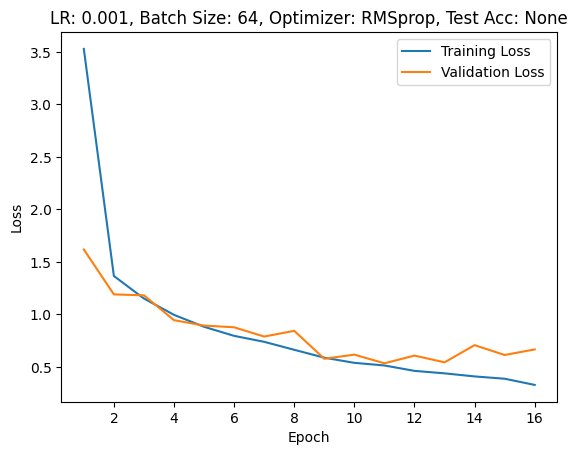

Running experiment with LR=0.001, Batch Size=128, Optimizer=RMSprop
[1] loss: 7.006 |  Val loss: 1.672 | acc: 0.24  | Val acc: 0.44 | 
[2] loss: 1.563 |  Val loss: 1.377 | acc: 0.45  | Val acc: 0.50 | 
[3] loss: 1.313 |  Val loss: 1.355 | acc: 0.54  | Val acc: 0.52 | 
[4] loss: 1.211 |  Val loss: 1.107 | acc: 0.58  | Val acc: 0.61 | 
[5] loss: 1.061 |  Val loss: 1.045 | acc: 0.63  | Val acc: 0.64 | 
[6] loss: 0.992 |  Val loss: 0.894 | acc: 0.66  | Val acc: 0.71 | 
[7] loss: 0.940 |  Val loss: 0.855 | acc: 0.69  | Val acc: 0.70 | 
[8] loss: 0.843 |  Val loss: 0.846 | acc: 0.72  | Val acc: 0.72 | 
[9] loss: 0.779 |  Val loss: 1.083 | acc: 0.73  | Val acc: 0.63 | 
[10] loss: 0.791 |  Val loss: 0.736 | acc: 0.73  | Val acc: 0.77 | 
[11] loss: 0.692 |  Val loss: 0.715 | acc: 0.77  | Val acc: 0.75 | 
[12] loss: 0.655 |  Val loss: 0.663 | acc: 0.78  | Val acc: 0.76 | 
[13] loss: 0.634 |  Val loss: 0.779 | acc: 0.78  | Val acc: 0.73 | 
[14] loss: 0.590 |  Val loss: 0.623 | acc: 0.80  | Val ac

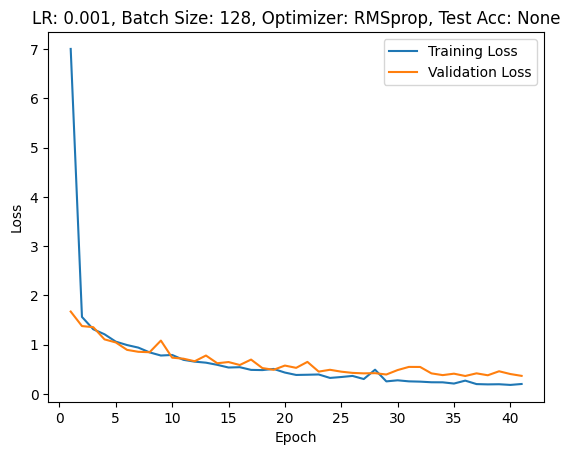

Running experiment with LR=0.0005, Batch Size=32, Optimizer=RMSprop
[1] loss: 2.080 |  Val loss: 1.384 | acc: 0.35  | Val acc: 0.48 | 
[2] loss: 1.289 |  Val loss: 1.187 | acc: 0.55  | Val acc: 0.58 | 
[3] loss: 1.075 |  Val loss: 1.015 | acc: 0.63  | Val acc: 0.64 | 
[4] loss: 0.917 |  Val loss: 0.923 | acc: 0.69  | Val acc: 0.68 | 
[5] loss: 0.799 |  Val loss: 0.796 | acc: 0.73  | Val acc: 0.71 | 
[6] loss: 0.691 |  Val loss: 0.757 | acc: 0.77  | Val acc: 0.74 | 
[7] loss: 0.627 |  Val loss: 0.637 | acc: 0.78  | Val acc: 0.79 | 
[8] loss: 0.545 |  Val loss: 0.614 | acc: 0.82  | Val acc: 0.79 | 
[9] loss: 0.511 |  Val loss: 0.511 | acc: 0.83  | Val acc: 0.82 | 
[10] loss: 0.472 |  Val loss: 0.501 | acc: 0.84  | Val acc: 0.83 | 
[11] loss: 0.440 |  Val loss: 0.497 | acc: 0.85  | Val acc: 0.84 | 
[12] loss: 0.389 |  Val loss: 0.462 | acc: 0.87  | Val acc: 0.84 | 
[13] loss: 0.377 |  Val loss: 0.466 | acc: 0.87  | Val acc: 0.85 | 
[14] loss: 0.345 |  Val loss: 0.426 | acc: 0.89  | Val ac

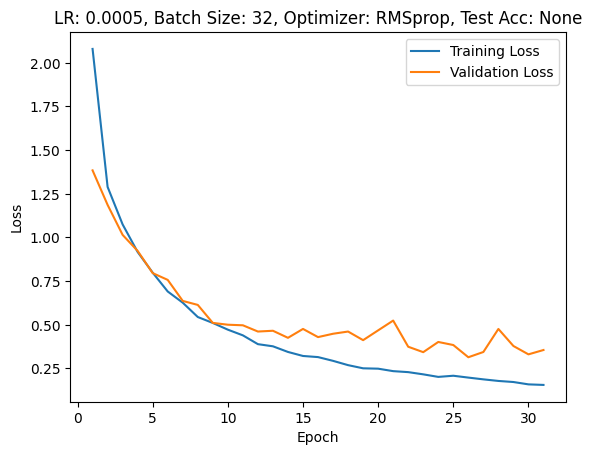

Running experiment with LR=0.0005, Batch Size=64, Optimizer=RMSprop
[1] loss: 2.432 |  Val loss: 1.525 | acc: 0.33  | Val acc: 0.43 | 
[2] loss: 1.403 |  Val loss: 1.294 | acc: 0.51  | Val acc: 0.54 | 
[3] loss: 1.196 |  Val loss: 1.143 | acc: 0.59  | Val acc: 0.61 | 
[4] loss: 1.034 |  Val loss: 1.043 | acc: 0.64  | Val acc: 0.64 | 
[5] loss: 0.921 |  Val loss: 0.948 | acc: 0.68  | Val acc: 0.66 | 
[6] loss: 0.815 |  Val loss: 0.805 | acc: 0.72  | Val acc: 0.71 | 
[7] loss: 0.726 |  Val loss: 0.720 | acc: 0.75  | Val acc: 0.76 | 
[8] loss: 0.631 |  Val loss: 0.708 | acc: 0.78  | Val acc: 0.76 | 
[9] loss: 0.595 |  Val loss: 0.636 | acc: 0.80  | Val acc: 0.78 | 
[10] loss: 0.574 |  Val loss: 0.584 | acc: 0.80  | Val acc: 0.81 | 
[11] loss: 0.492 |  Val loss: 0.561 | acc: 0.83  | Val acc: 0.80 | 
[12] loss: 0.481 |  Val loss: 0.524 | acc: 0.84  | Val acc: 0.83 | 
[13] loss: 0.458 |  Val loss: 0.570 | acc: 0.85  | Val acc: 0.81 | 
[14] loss: 0.426 |  Val loss: 0.506 | acc: 0.85  | Val ac

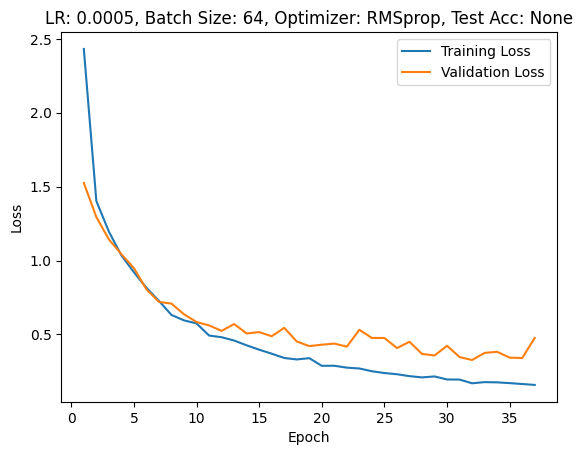

Running experiment with LR=0.0005, Batch Size=128, Optimizer=RMSprop
[1] loss: 5.746 |  Val loss: 1.655 | acc: 0.25  | Val acc: 0.40 | 
[2] loss: 1.562 |  Val loss: 1.449 | acc: 0.43  | Val acc: 0.48 | 
[3] loss: 1.370 |  Val loss: 1.225 | acc: 0.51  | Val acc: 0.58 | 
[4] loss: 1.245 |  Val loss: 1.181 | acc: 0.56  | Val acc: 0.58 | 
[5] loss: 1.139 |  Val loss: 1.080 | acc: 0.61  | Val acc: 0.62 | 
[6] loss: 1.063 |  Val loss: 0.987 | acc: 0.64  | Val acc: 0.65 | 
[7] loss: 0.973 |  Val loss: 0.955 | acc: 0.67  | Val acc: 0.68 | 
[8] loss: 0.926 |  Val loss: 0.904 | acc: 0.68  | Val acc: 0.67 | 
[9] loss: 0.861 |  Val loss: 0.813 | acc: 0.71  | Val acc: 0.73 | 
[10] loss: 0.785 |  Val loss: 0.791 | acc: 0.73  | Val acc: 0.73 | 
[11] loss: 0.723 |  Val loss: 0.712 | acc: 0.75  | Val acc: 0.75 | 
[12] loss: 0.706 |  Val loss: 0.685 | acc: 0.76  | Val acc: 0.77 | 
[13] loss: 0.637 |  Val loss: 0.658 | acc: 0.78  | Val acc: 0.77 | 
[14] loss: 0.616 |  Val loss: 0.696 | acc: 0.79  | Val a

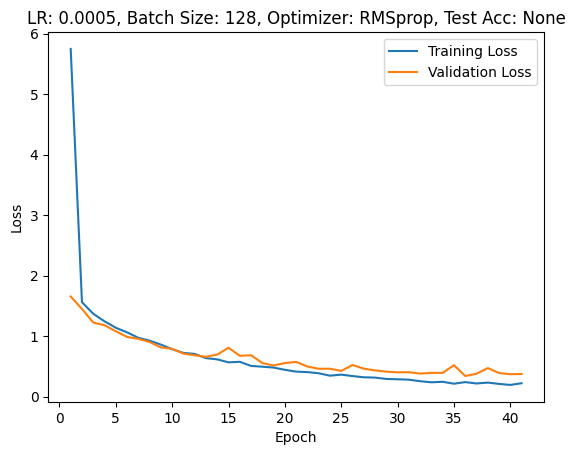

Running experiment with LR=0.0001, Batch Size=32, Optimizer=RMSprop
[1] loss: 1.805 |  Val loss: 1.416 | acc: 0.38  | Val acc: 0.49 | 
[2] loss: 1.337 |  Val loss: 1.315 | acc: 0.54  | Val acc: 0.54 | 
[3] loss: 1.187 |  Val loss: 1.119 | acc: 0.59  | Val acc: 0.61 | 
[4] loss: 1.072 |  Val loss: 1.059 | acc: 0.64  | Val acc: 0.63 | 
[5] loss: 0.980 |  Val loss: 0.947 | acc: 0.66  | Val acc: 0.66 | 
[6] loss: 0.914 |  Val loss: 0.878 | acc: 0.70  | Val acc: 0.70 | 
[7] loss: 0.842 |  Val loss: 0.940 | acc: 0.71  | Val acc: 0.67 | 
[8] loss: 0.785 |  Val loss: 0.769 | acc: 0.73  | Val acc: 0.73 | 
[9] loss: 0.721 |  Val loss: 0.737 | acc: 0.75  | Val acc: 0.76 | 
[10] loss: 0.691 |  Val loss: 0.734 | acc: 0.77  | Val acc: 0.77 | 
[11] loss: 0.641 |  Val loss: 0.706 | acc: 0.78  | Val acc: 0.76 | 
[12] loss: 0.620 |  Val loss: 0.688 | acc: 0.80  | Val acc: 0.77 | 
[13] loss: 0.592 |  Val loss: 0.626 | acc: 0.80  | Val acc: 0.79 | 
[14] loss: 0.563 |  Val loss: 0.615 | acc: 0.82  | Val ac

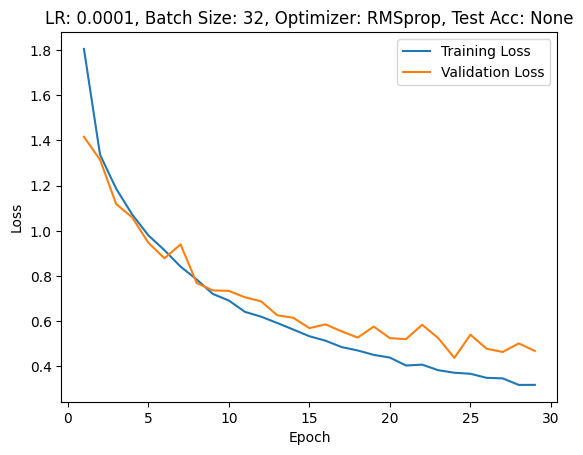

Running experiment with LR=0.0001, Batch Size=64, Optimizer=RMSprop
[1] loss: 1.891 |  Val loss: 1.464 | acc: 0.36  | Val acc: 0.48 | 
[2] loss: 1.391 |  Val loss: 1.273 | acc: 0.51  | Val acc: 0.57 | 
[3] loss: 1.275 |  Val loss: 1.180 | acc: 0.55  | Val acc: 0.58 | 
[4] loss: 1.145 |  Val loss: 1.087 | acc: 0.60  | Val acc: 0.63 | 
[5] loss: 1.093 |  Val loss: 1.046 | acc: 0.62  | Val acc: 0.64 | 
[6] loss: 1.021 |  Val loss: 0.991 | acc: 0.65  | Val acc: 0.67 | 
[7] loss: 0.962 |  Val loss: 0.952 | acc: 0.68  | Val acc: 0.68 | 
[8] loss: 0.919 |  Val loss: 0.854 | acc: 0.69  | Val acc: 0.72 | 
[9] loss: 0.877 |  Val loss: 1.012 | acc: 0.70  | Val acc: 0.65 | 
[10] loss: 0.834 |  Val loss: 0.797 | acc: 0.72  | Val acc: 0.74 | 
[11] loss: 0.796 |  Val loss: 0.895 | acc: 0.73  | Val acc: 0.70 | 
[12] loss: 0.769 |  Val loss: 0.800 | acc: 0.74  | Val acc: 0.74 | 
[13] loss: 0.740 |  Val loss: 0.752 | acc: 0.75  | Val acc: 0.76 | 
[14] loss: 0.708 |  Val loss: 0.700 | acc: 0.76  | Val ac

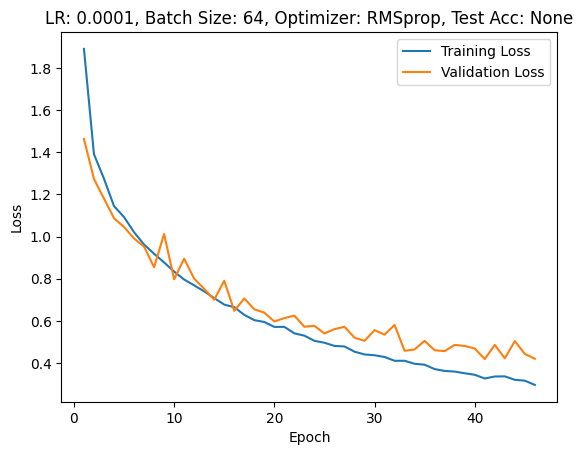

Running experiment with LR=0.0001, Batch Size=128, Optimizer=RMSprop


KeyboardInterrupt: 

In [18]:
#CNN Grid Search
def grid_search(learning_rate, batch_size, optimizer_name):
    #Seperate data based on batch size
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)
    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    #Initialize CNN
    net = UrbanSoundCNN()
    
    # Select optimizer based on optimizer_name
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")
    
    #Train and test model
    train_loss, val_loss, model, epochs = train_model(net, optimizer, train_dl, val_dl)
    test_accuracy = test_model(model, test_dl)  # Adjust test_model to return a performance metric

    # Plot Results for each set of parameters
    plt.figure()
    plt.plot(range(1, epochs + 1), train_loss, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')
    plt.legend()
    plt.title(f'LR: {learning_rate}, Batch Size: {batch_size}, Optimizer: {optimizer_name}, Test Acc: {test_accuracy}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    #Return losses and accuracy
    return train_loss, val_loss, test_accuracy

# Grid search parameters
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64, 128]
optimizers = ['Adam', 'SGD', 'RMSprop']

results = []
#Loop through hyperparameters and call grid search function
for optimizer_name in optimizers:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Running experiment with LR={lr}, Batch Size={batch_size}, Optimizer={optimizer_name}")
            train_loss, val_loss, test_accuracy = grid_search(lr, batch_size, optimizer_name)
            results.append((lr, batch_size, optimizer_name, min(val_loss), test_accuracy))

# Sort results based on validation loss
results.sort(key=lambda x: x[3])

# Print the sorted results
for result in results:
    print(f"LR: {result[0]}, Batch Size: {result[1]}, Optimizer: {result[2]}, Min Val Loss: {result[3]}, Test Accuracy: {result[4]}")

[1] loss: 2.103 |  Val loss: 1.596 | acc: 0.30  | Val acc: 0.45 | 
[2] loss: 1.514 |  Val loss: 1.369 | acc: 0.47  | Val acc: 0.50 | 
[3] loss: 1.336 |  Val loss: 1.296 | acc: 0.53  | Val acc: 0.55 | 
[4] loss: 1.253 |  Val loss: 1.291 | acc: 0.57  | Val acc: 0.53 | 
[5] loss: 1.185 |  Val loss: 1.152 | acc: 0.60  | Val acc: 0.58 | 
[6] loss: 1.138 |  Val loss: 1.102 | acc: 0.61  | Val acc: 0.61 | 
[7] loss: 1.093 |  Val loss: 1.204 | acc: 0.63  | Val acc: 0.57 | 
[8] loss: 1.053 |  Val loss: 1.019 | acc: 0.63  | Val acc: 0.65 | 
[9] loss: 1.019 |  Val loss: 1.054 | acc: 0.65  | Val acc: 0.66 | 
[10] loss: 0.970 |  Val loss: 1.030 | acc: 0.67  | Val acc: 0.65 | 
[11] loss: 0.928 |  Val loss: 0.932 | acc: 0.70  | Val acc: 0.69 | 
[12] loss: 0.922 |  Val loss: 0.920 | acc: 0.69  | Val acc: 0.68 | 
[13] loss: 0.892 |  Val loss: 0.879 | acc: 0.70  | Val acc: 0.69 | 
[14] loss: 0.856 |  Val loss: 0.824 | acc: 0.71  | Val acc: 0.73 | 
[15] loss: 0.837 |  Val loss: 0.807 | acc: 0.72  | Val ac

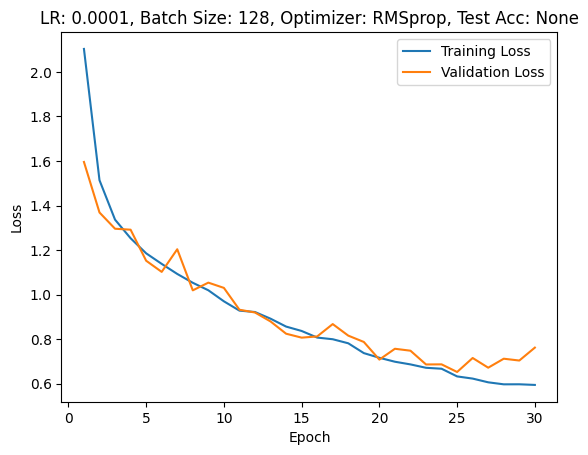

In [28]:
#CNN Search
def search(learning_rate, batch_size, optimizer_name):
    #Seperate data based on batch size
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)
    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    #Initialize CNN
    net = UrbanSoundCNN()
    
    # Select optimizer based on optimizer_name
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")
    
    #Train and test model
    train_loss, val_loss, model, epochs = train_model(net, optimizer, train_dl, val_dl)
    test_accuracy = test_model(model, test_dl)  # Adjust test_model to return a performance metric
    
    model_filename = f'model_LR_{learning_rate}_BS_{batch_size}_OPT_{optimizer_name}.pth'
    torch.save(model.state_dict(), model_filename)
    print(f'Model saved to {model_filename}')
    
    # Plot Results for each set of parameters
    plt.figure()
    plt.plot(range(1, epochs + 1), train_loss, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')
    plt.legend()
    plt.title(f'LR: {learning_rate}, Batch Size: {batch_size}, Optimizer: {optimizer_name}, Test Acc: {test_accuracy}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    #Return losses and accuracy
    return train_loss, val_loss, test_accuracy

# Grid search parameters
learning_rates = 0.005
batch_sizes = 128
optimizers = 'RMSprop'

train_loss, val_loss, test_accuracy = search(lr, batch_size, optimizer_name)

